In [51]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import pickle

In [74]:
# Put csv into df
df = pd.read_csv('data.csv')

In [85]:
# Separate features and label
X = df.drop(['score', 'delta', 'score_prev'], axis=1)

# Save column names
X.sort_index(axis=1, inplace=True)
columns = X.columns

score = df['score']
score_prev = df['score_prev']
delta = df['delta']
weights = np.power(np.clip(score_prev- score, 0, 1)*delta, 2)
# Calculate mu
mu = SimplifiedWickelgren.calculate_mu(score, delta)

# Fit for mu
model = LinearRegression()
model.fit(X, mu, sample_weight=weights)
mu_pred = model.predict(X)
score_pred = SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta)
# Save weights and intercepts

<AxesSubplot:>

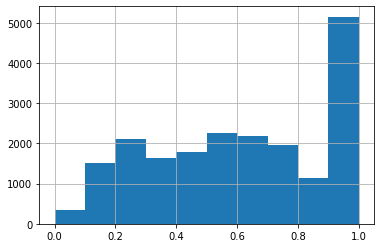

In [86]:
score_pred.hist()

In [87]:
# Save columns
with open('column_names.pkl', 'wb') as file:
    pickle.dump(columns, file)

# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [61]:
class MTR:
    def __init__(self):
        self.model = LinearRegression
        self.column_names = []
    
    def load(self):
        with open('model.pkl', 'rb') as file:
            self.model = pickle.load(file)
        
        with open('column_names.pkl', 'rb') as file:
            self.column_names = pickle.load(file)
    
    def predict_to_df(self, df):
        X = df[self.column_names]
        delta = df['delta']
        mu_pred = self.model.predict(X)
        df['score_pred'] = SimplifiedWickelgren.calculate_retention_rate(mu_pred, delta)
        return df
        
        

<AxesSubplot:>

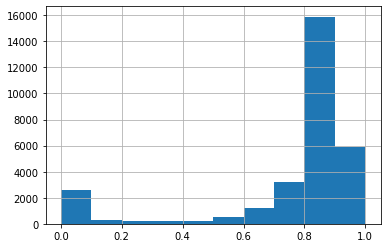

In [69]:
mtr = MTR()
mtr.load()
mtr.predict_to_df(df)['score_pred'].hist()

<AxesSubplot:>

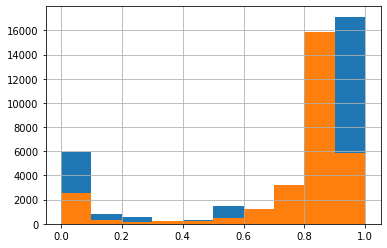

In [66]:
pd.DataFrame({'mu': mu, 'mu_pred': mu_pred, 'score': score, 'score_pred': score_pred})
score.hist()
score_pred.hist()

In [37]:
X.columns

Index(['ALL_amount', 'ALL_leading_failures_amount',
       'ALL_leading_failures_seconds', 'ALL_leading_recalls_amount',
       'ALL_leading_recalls_seconds', 'ALL_longest_leading_recalls_seconds',
       'BOOK_DRILL_CLICK_amount', 'BOOK_DRILL_CLICK_seconds',
       'BOOK_DRILL_SCROLL_amount', 'BOOK_DRILL_SCROLL_seconds',
       'FIRST_EXPOSURE_seconds', 'REVISION__CLICKED_amount',
       'REVISION__CLICKED_seconds', 'REVISION__NOT_CLICKED_amount',
       'REVISION__NOT_CLICKED_seconds', 'TEXT__SENTENCE_CLICK_amount',
       'TEXT__SENTENCE_CLICK_seconds', 'TEXT__SENTENCE_READ_amount',
       'TEXT__SENTENCE_READ_seconds', 'TEXT__WORD_HIGHLIGHTED_amount',
       'TEXT__WORD_HIGHLIGHTED_seconds',
       'VIDEO__TRANSLATION_WAS_REVEALED_amount',
       'VIDEO__TRANSLATION_WAS_REVEALED_seconds', 'VIDEO__WAS_SEEN_amount',
       'VIDEO__WAS_SEEN_seconds'],
      dtype='object')

In [39]:
MU_MAX = 10e10
MU_MIN = 10e-10

class SimplifiedWickelgren:

    @staticmethod
    def calculate_mu(retention_rate, delta):
        delta_ = delta / (24 * 60 * 60)
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return -1. * np.divide(np.log(1 + delta_), (np.log(retention_rate_clipped)))

    @staticmethod
    def calculate_retention_rate(mu, delta):
        delta_ = delta / (24 * 60 * 60)
        mu = np.clip(mu, MU_MIN, MU_MAX)
        exponent = np.divide(-1.,mu)
        return np.power(1. + delta_, exponent)

    @staticmethod
    def get_name():
        return "SWP"